In [12]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier,\
                                      GBTClassifier,LinearSVC
from pyspark.ml.feature import Tokenizer,StopWordsRemover,\
                               CountVectorizer,IDF,NGram,\
                               VectorAssembler,Word2Vec,PCA
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col,udf,regexp_replace,lower
from pyspark.sql.types import ArrayType,StringType,IntegerType
from wordcloud import WordCloud

# Path to Data Bucket

In [2]:
file_path = '/Users/shashankp/Desktop/Big Data/Final Project/data/sentiment140.csv'

# Data Visualization with Seaborn and wordcloud

## Helper Functions 

In [162]:
def plot_counts(col,data_to_plot,xlabel,ylabel,title,
                xrotate=0,size=None):
    if(size != None):
        plt.figure(figsize=size)
    plt.xticks(rotation=xrotate)
    plt.title(title)  
    plt.tight_layout()
    ax = sns.countplot(x=col,data=data_to_plot)
    ax.set(xlabel=xlabel,ylabel=ylabel)
    
def plot_wordcloud(col):
    text = " ".join([sentence for sentence in col])
    wcl = WordCloud(max_words=100,max_font_size=40).generate(text)
    plt.figure()
    plt.imshow(wcl,interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Load data

In [163]:
tweets_data = pd.read_csv(file_path,header=None,encoding="ISO-8859-1",
                          usecols=[0,4,5])
tweets_data.head()

,0,4,5
0,0,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,scotthamilton,is upset that he can't update his Facebook by ...
2,0,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,ElleCTF,my whole body feels itchy and like its on fire
4,0,Karoli,"@nationwideclass no, it's not behaving at all...."


## Number of positive, negative, neutral tweets 

It turns out that all tweet labels provided are either positive or negative. There are no neutral tweets in the dataset.

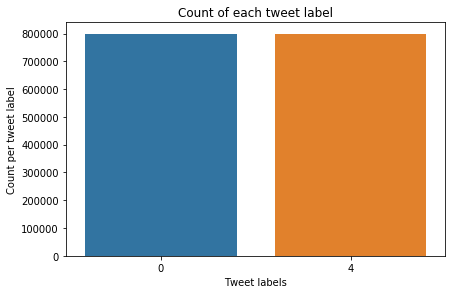

In [164]:
plot_counts(0,tweets_data,"Tweet labels","Count per tweet label",
            "Count of each tweet label")

## Number of users who made X number of tweets

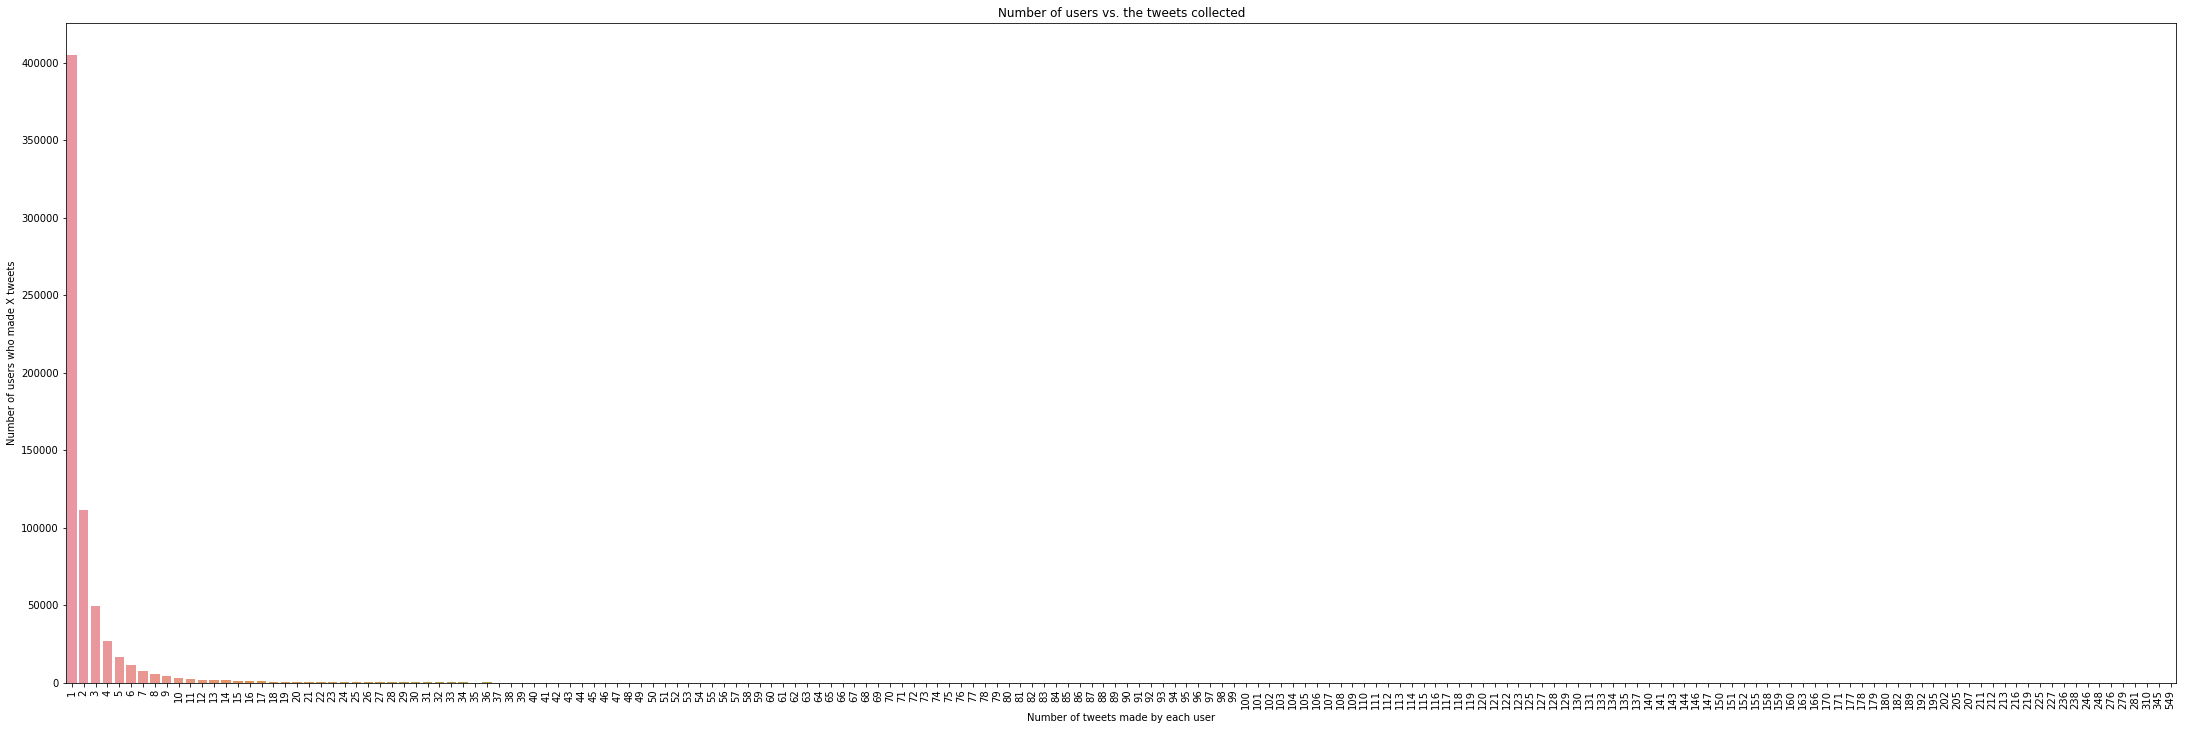

In [165]:
tweets_count_per_user = tweets_data.drop([5],axis=1)\
                                   .groupby([4])\
                                   .agg(['count'])\
                                   .reset_index()[0]
plot_counts('count',tweets_count_per_user,"Number of tweets made by each user",
            "Number of users who made X tweets",
            "Number of users vs. the tweets collected",
            xrotate=90,size=(30,10))

## Box plot of the character length of each tweet 

([], <a list of 0 Text xticklabel objects>)

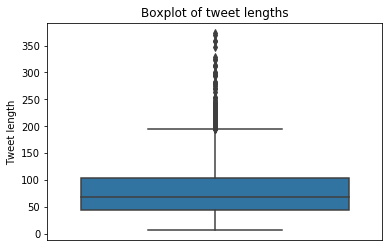

In [166]:
lengths = tweets_data[5].apply(lambda sen: len(sen))
sns.boxplot(data=lengths)
plt.ylabel('Tweet length')
plt.title('Boxplot of tweet lengths')
plt.xticks([])

## Plot wordcloud for positive tweets 

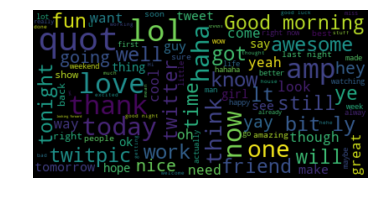

In [168]:
column = tweets_data[tweets_data[0]==4][5]
plot_wordcloud(column)

## Plot wordcloud for negative tweets 

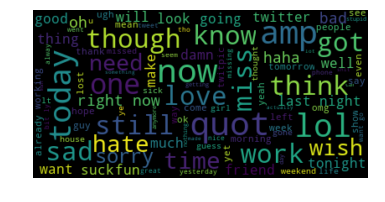

In [169]:
column = tweets_data[tweets_data[0]==0][5]
plot_wordcloud(column)

## Delete the pandas dataframes as we don't need them

In [10]:
del tweets_data
del tweets_count_per_user
del lengths

# Feature Extraction with Spark

## Helper Functions 

In [13]:
def remove_words_with_prefix(sentence,prefix):
    # Given a sentence, obtain its words and 
    # remove those that start with a prefix
    words = sentence.split()
    new_sentence = " ".join([word \
                             for word in words \
                             if not word.startswith(prefix)])
    return new_sentence

def remove_words_with_prefixes(sentence,prefixes):
    # Remove words from the document that start with the 
    # given list of prefixes. Then strip the sentence, split
    # it and rejoin to prevent extra spaces in between
    new_sentence = sentence
    for prefix in prefixes:
        new_sentence = remove_words_with_prefix(new_sentence,
                                               prefix)
    return " ".join([word for word in new_sentence.split()])

def remove_punct(df,column):
    # Make entire column lowercase
    df = df.withColumn(column,lower(col(column)))
    # Replace n't with not as part of preprocessing step and 's with is
    df = df.withColumn(column,regexp_replace(col(column),"n't\b"," not"))
    # Replace non-alphabetical characters with empty
    df = df.withColumn(column,regexp_replace(col(column),"[^a-zA-Z0-9#]+"," "))
    return df

def filter_tokens(tokens):
    # Remove tokens whose length is too small
    new_tokens = []
    for token in tokens:
        if len(token) > 1:
            new_tokens.append(token)
    return new_tokens

def apply_udf(df,udf,column,name):
    # Apply the user defined function to the dataframe column and 
    # alias the newly created column name to column
    return df.withColumn(name,udf(col(column)))\
             .drop(col(column))\
             .withColumnRenamed(name,column)

def binarize(value):
    # Simply binarizes each value bigger than 0 to 1 and 0 to 0
    return 0 if value == 0 else 1

# Create Spark Session

In [14]:
spark = SparkSession.builder\
                    .appName("Sentiment-Analysis")\
                    .getOrCreate()

# Read File in Spark 

In [25]:
reader = spark.read
reader.option("header",None)
reader.option("inferSchema",True)
reader.option("encoding","iso-8859-1")
tweetsDf = reader.csv(file_path)
tweetsDf = tweetsDf.selectExpr("_c0 as sentiment","_c5 as tweet")
tweetsDf.show(5)

+---------+--------------------+
|sentiment|               tweet|
+---------+--------------------+
|        0|@switchfoot http:...|
|        0|is upset that he ...|
|        0|@Kenichan I dived...|
|        0|my whole body fee...|
|        0|@nationwideclass ...|
+---------+--------------------+
only showing top 5 rows



# Split into train/test data 

In [26]:
splits = tweetsDf.randomSplit([0.8,0.2],1234)
train = splits[0]
test = splits[1]
test.show(5)

+---------+--------------------+
|sentiment|               tweet|
+---------+--------------------+
|        0|       i really2 ...|
|        0|      My current ...|
|        0|      this weeken...|
|        0|            #canucks|
|        0|     &lt;- but mu...|
+---------+--------------------+
only showing top 5 rows



# Preprocess Tweets and relabel columns

Remove @ mentions, hyperlinks, and punctuations as they do not help in predicting the sentiment of the tweet. Also, make everything lowercase. In addition, binarize the sentiment labels.

## Helper Function 

In [27]:
def clean_df(df):
    # Clean tweets and binarize sentiment labels
    prefixes = ['@','http://','https://','www.','&','<',
                '>']
    preprocess_tweet = udf(lambda sen: remove_words_with_prefixes(sen,prefixes),
                          StringType())
    binar = udf(lambda val: binarize(val),IntegerType())
    df = apply_udf(df,preprocess_tweet,"tweet","preprocess_tweet")
    df = remove_punct(df,"tweet")
    df = apply_udf(df,binar,"sentiment","new_label")
    df = df.withColumnRenamed("sentiment","label")
    return df

In [28]:
train = clean_df(train)
test = clean_df(test)
test.show(5)

+--------------------+-----+
|               tweet|label|
+--------------------+-----+
|i really2 don t l...|    0|
|my current headse...|    0|
|this weekend has ...|    0|
|            #canucks|    0|
|but mustache man ...|    0|
+--------------------+-----+
only showing top 5 rows



# Tokenize and drop unnecessary columns 

Remove stopwords and create tokens using a pipeline and then filter the tokens whose length is too small.

In [29]:
tokenizer = Tokenizer(inputCol="tweet",outputCol="tokens")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(),
                          outputCol="no_stopwords")
tok_pip = Pipeline(stages=[tokenizer,remover])
model = tok_pip.fit(train)
filter_tok = udf(lambda tokens: filter_tokens(tokens),ArrayType(StringType()))
train = model.transform(train).drop("tweet","tokens")\
                                .withColumnRenamed("no_stopwords",
                                                  "tweet")
test = model.transform(test).drop("tweet","tokens")\
                              .withColumnRenamed("no_stopwords",
                                                "tweet")
train = apply_udf(train,filter_tok,"tweet","filtered_tweet")
test = apply_udf(test,filter_tok,"tweet","filtered_tweet")
train.show(5)

+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|    0|[really2, like, c...|
|    0|[current, headset...|
|    0|[weekend, sucked,...|
|    0|          [#canucks]|
|    0|[mustache, man, d...|
+-----+--------------------+
only showing top 5 rows



# Drop columns with null values 

In [30]:
train = train.dropna()
test = test.dropna()
train.show(5)

+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|    0|[really2, like, c...|
|    0|[current, headset...|
|    0|[weekend, sucked,...|
|    0|          [#canucks]|
|    0|[mustache, man, d...|
+-----+--------------------+
only showing top 5 rows



# Word2Vec features

In [31]:
word2vec = Word2Vec(vectorSize=30,minCount=50,
                    inputCol="tweet",
                    outputCol="features")
model = word2vec.fit(train)
train = model.transform(train).drop("tweet")
test = model.transform(test).drop("tweet")
test.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.0238731764256...|
|    0|[-0.0237927422858...|
|    0|[0.11640235448721...|
|    0|[0.15244324567417...|
|    0|[0.02465228071170...|
+-----+--------------------+
only showing top 5 rows



# Training and Evaluating Spark's ML library models

## Helper Function 

In [33]:
def cross_validate_test(model,params,evaluator,folds,
                        train,test):
    # Performs cross validation on the model and returns the 
    # predictions made by the best model
    cv = CrossValidator(estimator=model,
                        estimatorParamMaps=params,
                        evaluator=evaluator,
                        numFolds=folds)
    model = cv.fit(train)
    return model.transform(test)

def print_different_metric_scores(predictions):
    # Prints different metric scores for the model based on the 
    # predictions
    
    #Multiclass classification metrics
    metrics = ['f1','weightedPrecision','weightedRecall','accuracy']
    for metric in metrics:
        ev = MulticlassClassificationEvaluator(labelCol="label",
                                               predictionCol="prediction",
                                               metricName=metric)
        score = ev.evaluate(predictions)
        print(metric + " {} ".format(score))

## Common Evaluator for training cross validated models 

In [35]:
evaluator = MulticlassClassificationEvaluator(labelCol="label",
                                              predictionCol="prediction",
                                              metricName="f1")

## LinearSVC

In [159]:
svm = LinearSVC(maxIter=20)
paramGrid = ParamGridBuilder().addGrid(svm.regParam,[0.01,0.1])\
                              .build()
predictions = cross_validate_test(svm,paramGrid,evaluator,4,
                                  train,test)
print_different_metric_scores(predictions)

f1 0.5564527031118092 
weightedPrecision 0.6511205990436113 
weightedRecall 0.5966543389042336 
accuracy 0.5966543389042336 


## Logistic Regression 

In [160]:
lr = LogisticRegression(maxIter=20)
paramGrid = ParamGridBuilder().addGrid(lr.regParam,[0.01,0.1])\
                              .addGrid(lr.elasticNetParam,[0,0.5,1])\
                              .build()
predictions = cross_validate_test(lr,paramGrid,evaluator,4,
                                  train,test)
print_different_metric_scores(predictions)

f1 0.6352896598064361 
weightedPrecision 0.638311177071972 
weightedRecall 0.6365151444220776 
accuracy 0.6365151444220776 


## Random Forest 

In [36]:
rf = RandomForestClassifier()
paramGrid = ParamGridBuilder().addGrid(rf.numTrees,[15,20,25])\
                              .addGrid(rf.maxDepth,[5,6,7])\
                              .build()
predictions = cross_validate_test(rf,paramGrid,evaluator,4,
                                  train,test)
print_different_metric_scores(predictions)

f1 0.6536135140355775 
weightedPrecision 0.6546982559771761 
weightedRecall 0.6539893575519249 
accuracy 0.6539893575519249 


## Gradient Boosting 

In [39]:
gb = GBTClassifier(maxIter=20)
predictions = cross_validate_test(gb,paramGrid,evaluator,4,
                                  train,test)
print_different_metric_scores(predictions)

f1 0.6636652612488684 
weightedPrecision 0.6641386279719605 
weightedRecall 0.6638172370207387 
accuracy 0.6638172370207387 
